# Preparation

In [ ]:
from IPython.display import Audio
import soundfile as sf
from scipy.io.wavfile import write
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from random import randrange

In [108]:
audio_file = "chromatik-forte-ks-1.wav"  
y, sr = librosa.load(audio_file, sr=None)
#Audio(data=y, rate=sr) # original music file, commented out to save memory

# Note trimming

Higher values of top_db result in more aggressive silence detection (more parts of the audio are treated as silent). Lower values of top_db are stricter, meaning fewer segments are considered silent. 

After increasing top_db to 42 from 16, as it was before, the segments are better at capturing decay.

In [109]:
y_trimmed = y[10*sr:] # removing noise in the beginning that lasted approximately 10 seconds
intervals = librosa.effects.split(y_trimmed, top_db=42)  # getting individual notes, parameter top_db defines how sensitive the cut is
print(f"Number of intervals is {len(intervals)}")

Number of intervals is 41


After the first extraction phase, there are 41 notes, since it sometimes includes noise. It seems that simply filtering it by length (using the assumption that each note is at least 0.5 seconds) does the job.  

I'm not sure, if pre-last note was meant to be so short. In case it was a mistake, increasing a threshold to 0.7 ignores it and the entire process results into 34 notes.

In [110]:
min_note_duration =  sr*0.5  # 0.5 seconds threshold
diff =  [intervals[i][1] - intervals[i][0] for i in range(len(intervals))]  # calculating the time difference between extracted notes
filtered_intervals =  [interval for i, interval in enumerate(intervals) if diff[i] >= min_note_duration] # removing noise that last less a thershold
print(f"Number of exctracted notes after filtering is {len(filtered_intervals)}")

Number of exctracted notes after filtering is 35


As for capturing the attack times, this task is a bit more challenging. My idea is to simply add a very short time interval at the beginning and after the note to capture the attacks and decays.

In [111]:
start_addition = int(0.2*sr)
end_addition =  int(0.25*sr)
notes = []                                           # array that contains all extracted notes
for i, (start, end) in enumerate(filtered_intervals):
    note = y_trimmed[start-start_addition:end+ end_addition]   # adding little time the beginning for attack 
    notes.append(note)

Here is a plot and audio of a random note to see what is captured. 

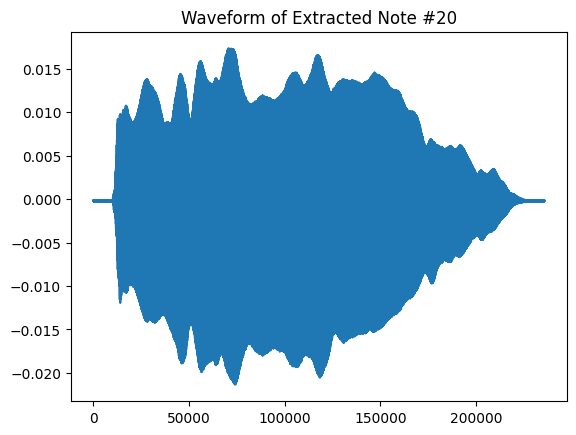

In [112]:
num_note = randrange(len(filtered_intervals))
plt.plot(notes[num_note])  # Plot the waveform of the extracted note
plt.title(f"Waveform of Extracted Note #{num_note}")
plt.show()
Audio(data=notes[num_note], rate=sr)

As a quick sanity check, let's concatenate everything back again, separating each note by click, speeding it up for convenience.

In [113]:
# for easier evaluation of result we concatenate all notes back together adding clicks in-between
click_duration =1  
click_freq = 1000  
click_sr = 22050 

t = np.linspace(0, click_duration, int(click_sr * click_duration), endpoint=False)
click = 0.1 * np.sin(2 * np.pi * click_freq * t) 

concatenated_audio = notes[0]
for note in notes[1:]:
    concatenated_audio = np.concatenate((concatenated_audio, click, note))
y_clicks_fast = librosa.effects.time_stretch(concatenated_audio, rate=3)
Audio(data=y_clicks_fast, rate=sr)#

The following plot shows the overall structure of extracted notes. As I already mentioned, the pre-last note is a bit too short and looks weird on a plot, but it is easy to fix by the right threshold.  

35


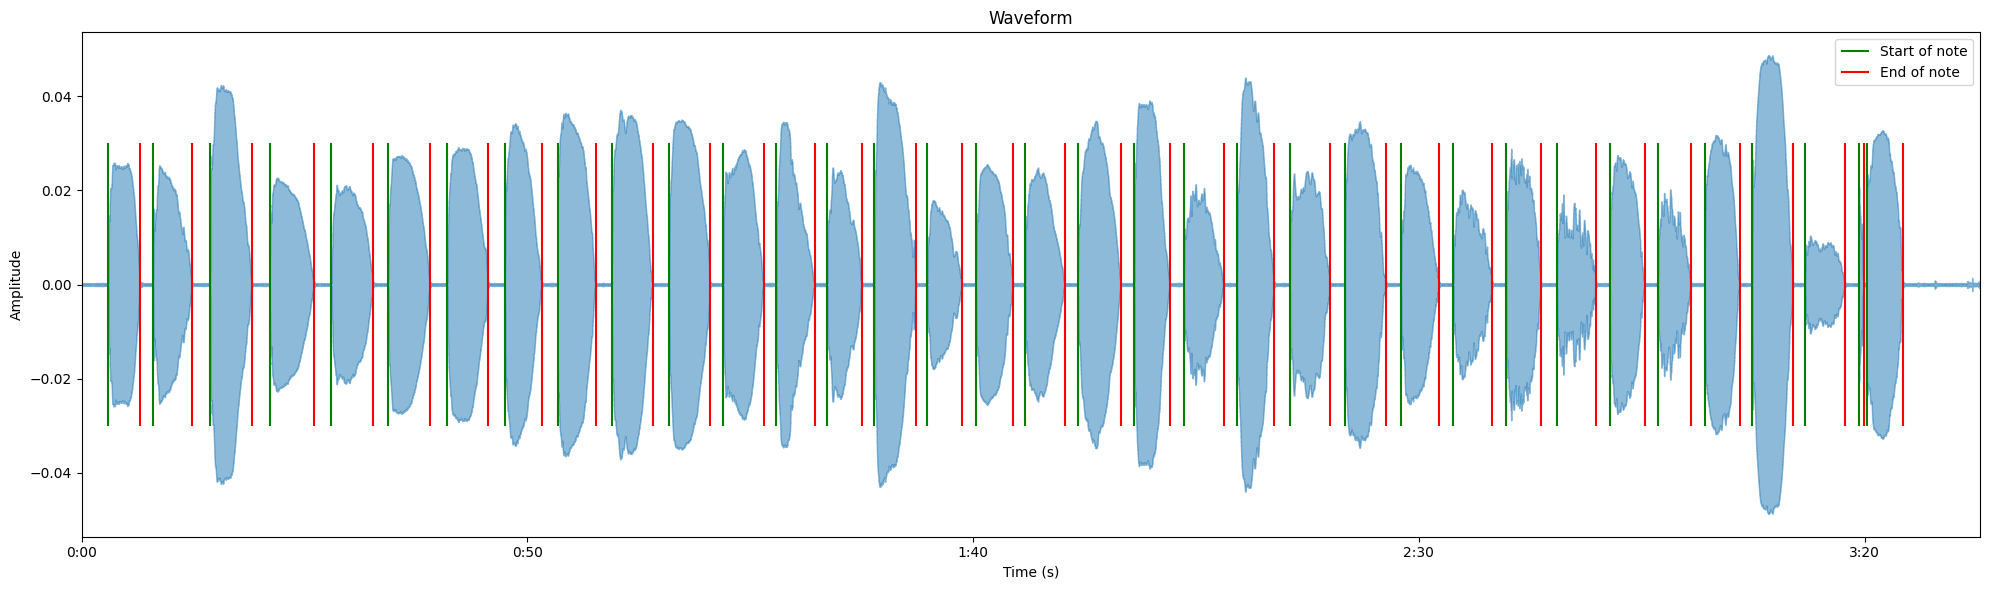

In [114]:
frame_length = 2048  # Length of each frame for analysis
hop_length = 512     # Number of samples between frames

rms = librosa.feature.rms(y=y_trimmed, frame_length=frame_length, hop_length=hop_length)[0]
amplitude = np.abs(y_trimmed)

frames = range(len(rms))
times = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
peaks, _ = find_peaks(rms, height=0.01, distance=200)  # Adjust height and distance as needed

num_peaks = len(peaks)
print(num_peaks)

plt.figure(figsize=(20, 6))
librosa.display.waveshow(y_trimmed, sr=sr, alpha=0.5)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
for i, (start, end) in enumerate(filtered_intervals):
    plt.vlines(start/ sr, -0.03, 0.03, colors = 'green',  label='Start of note' if i == 0 else "")  # green lines mark the start of the extracted notes
    plt.vlines(end/ sr, -0.03, 0.03, colors = 'red', label='End of note' if i == 0 else "")   # red lines mark the ending of the notes
plt.legend(loc='upper right')
plt.xlim(0, len(y_trimmed) / sr)
plt.tight_layout()
plt.show()

# Note detection

In order to predict the note name, we can librosa function based on the fundamental frequency.

In [115]:
def detect_note(note,sr = 48000):

    # get the fundamental frequency f0
    f0 = librosa.yin(
        note,
        sr=sr,
        fmin=librosa.note_to_hz("C2"),  
        fmax=librosa.note_to_hz("C7"),  
    )

    # remove frames with no f0
    f0_valid = f0[~np.isnan(f0)]
    if len(f0_valid) == 0:
        raise ValueError("No valid f0 detected. Maybe too noisy or silence?")

    # use median f0 as an estimate
    f0_median = np.median(f0_valid)

    # convert frequency to note name
    note_name = librosa.hz_to_note(f0_median)

    return note_name

In [116]:
# sanity check to see if the note detection works
for i in range(5):
    note_name = detect_note(notes[i], sr)
    print(f"Note #{i+1}: {note_name}")

Note #1: A2
Note #2: A♯2
Note #3: B2
Note #4: C3
Note #5: C♯3


# Extracting dynamics

Extracting dynamics is a little more challenging and there are no ready-to-use tool in Python. However, we can estimate the loudness of all given notes using RMS  and then divide them into bins.

In [117]:
def estimate_loudness_db(note):
    # RMS amplitude
    rms = np.sqrt(np.mean(note**2))
    
    # convert to dB
    rms_db = 20 * np.log10(rms + 1e-12)
    return rms_db

In [118]:
loudness_values = []
for i in range(len(notes)):
   loudness = estimate_loudness_db(notes[i])
   loudness_values.append(loudness)
   
# getting quartiles based on loudness and associating them with dynamics
p_mp = np.percentile(loudness_values, 25)
mp_mf = np.percentile(loudness_values, 50)
mf_f = np.percentile(loudness_values, 75)
print(p_mp, mp_mf, mf_f)

-42.31000276281318 -40.48729804432301 -38.5321337499755


In [119]:
def loudness_to_dynamic(rms_db, boundaries):
    # converting loudness to dynamics based on boundaries
    if rms_db < boundaries[0]:
        return "p"   
    elif rms_db < boundaries[1]:
        return "mp"  
    elif rms_db < boundaries[2]:
        return "mf"  
    else:
        return "f"   

In [120]:
from collections import Counter
dynamics = []
for i in range(len(notes)):
   loudness = estimate_loudness_db(notes[i])
   loudness_values.append(loudness)
   dynamic = loudness_to_dynamic(loudness, boundaries=(p_mp, mp_mf, mf_f))
   dynamics.append(dynamic)
# overall counts of different dynamics values in the dataset
Counter(dynamics)

Counter({'mf': 9, 'p': 9, 'f': 9, 'mp': 8})

# Saving

Lastly, we need to save everything.

In [ ]:
import os
import shutil
os.makedirs("results", exist_ok=True)
for i, note in enumerate(notes):
    note_name = detect_note(note, sr)
    dynamics = loudness_to_dynamic(estimate_loudness_db(note), boundaries=(p_mp, mp_mf, mf_f))
    wav_file = f"results\\heckelphone_{dynamics}_{note_name}.wav"    # saving each note in a separate file
    sf.write(wav_file,note, sr)
wav_file = "results\\concatenated_result.wav"    # saving concatenated notes in one file
sf.write(wav_file,concatenated_audio, sr)
shutil.make_archive("results", 'zip',"results")  # saving zip with results